## "Raw" notebook
This is the raw jupyter notebook used for analysis. If you wish to reproduce our results, run all cells of this notebook in a properly setup EMR notebook.

In [1]:
# Installing newest version of pip to resolve compatibility issues
# requests for fetching terrain tile data, matplotlib for visualisation
# sc is the default spark context
sc.install_pypi_package("pip==22.2.2")
sc.install_pypi_package("requests")
sc.install_pypi_package("matplotlib")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1694360557105_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 12.8 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 95.4 MB/s eta 0:00:00
 

In [2]:
# stdlib imports
from time import time
from itertools import product
from typing import Tuple, List, NamedTuple
from collections import namedtuple

# util libraries imports
import numpy as np
import matplotlib.pyplot as plt

# PySpark related imports
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as spark_func


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Constants used throughout the notebook
Tile: NamedTuple = namedtuple("Tile", ("zoom", "x", "y"))

TEMP_DIR: str = "data"
DATASET_URL_FORMAT: str = "s3://elevation-tiles-prod/terrarium"
ZOOM: int = 3

TILE_WIDTH: int = 256
TILE_HEIGHT: int = 256
CHANNELS_NUM: int = 3

RED_CHANNEL_MULTIPLIER: int = 256
GREEN_CHANNEL_MULTIPLIER: int = 1
BLUE_CHANNEL_MULTIPLIER: int = 1/256

INCREMENT_OFFSET: int = 32768

# Bounds, (latitude1, longitude1), (latitude2,  longitude2) found using bboxfinder.com
BOUNDS: Tuple[float, ...] = (72.711037, -172.964981, -55.554805, -21.269288)


GRADIENT_GROUPS = {
    0: 2,
    1: 10,
    2: 50,
    3: 150,
    4: 500,
    5: 1500
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Functions related to transforming data, later used as map functions on the RDD 

In [4]:
def mercator_projection(lat: float, lon: float, zoom: int) -> Tuple[int, int, int]:
    """
    Convert latitude, longitude to z/x/y tile coordinate at given zoom.

    Parameters:
    - lat (float): Latitude in degrees.
    - lon (float): Longitude in degrees.
    - zoom (int): Zoom level.

    Returns:
    - Tuple[int, int, int]: A tuple containing the zoom level, x and y tile coordinates.
    """
    # Convert latitude and longitude to radians
    x1: float = lon * np.pi / 180.
    y1: float = lat * np.pi / 180.

    # Mercator projection https://en.wikipedia.org/wiki/Mercator_projection
    x2 = x1
    y2 =  np.log(np.tan(0.25 * np.pi + 0.5 * y1))

    # Transform to tile space
    tiles = 2 ** zoom
    diameter =  2 * np.pi
    x3 = int(tiles * (x2 + np.pi) / diameter)
    y3 = int(tiles * (np.pi - y2) / diameter)

    return zoom, x3, y3


def get_elevation(tile: np.ndarray) -> np.ndarray:
    """
    Calculates elevation for an entire map tile.

    Parameters:
    - tile (np.ndarray): A NumPy array representing the tile.

    Returns:
    - np.ndarray: A NumPy array containing the elevation values.
    """
    return np.array([list(map(calculate_elevation, row)) for row in tile])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Functions related to fetching data and other miscellanous transformations

In [5]:
def get_tiles(zoom: int, lat1: float, lon1: float, lat2: float, lon2: float) -> List[Tile]:
    """
    Convert geographic bounds into a list of tile coordinates at given zoom.

    Parameters:
    - zoom (int): Zoom level.
    - lat1, lon1, lat2, lon2 (float): Geographic bounds.

    Returns:
    - List[Tile]: A list of Tile namedtuples.
    """
    # Convert to geographic bounding box
    min_lat = min(lat1, lat2)
    min_lon =  min(lon1, lon2)
    max_lat = max(lat1, lat2)
    max_lon =  max(lon1, lon2)

    # Convert to tile-space bounding box
    _, xmin, ymin = mercator_projection(max_lat, min_lon, zoom)
    _, xmax, ymax = mercator_projection(min_lat, max_lon, zoom)

    # Generate a list of tiles
    xs = range(xmin, xmax+1)
    ys = range(ymin, ymax+1)

    return [Tile(zoom, x, y) for (y, x) in product(ys, xs)]

def generate_links(tiles: List[Tile]) -> List[str]:
    """
    Returns links to s3 bucket for given tiles.

    Parameters:
    - tiles (List[Tile]): A list of Tile namedtuples.

    Returns:
    - List[str]: A list of URLs.
    """
    return [f"{DATASET_URL_FORMAT}/{tile.zoom}/{tile.x}/{tile.y}.png" for tile in tiles]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Functions related to elevations, whether it's coloring the map or calculating color of a pixel that should be displayed

In [6]:
def calculate_elevation(rgb: Tuple[int, int, int]) -> float:
    """
    Calculates elevation based on RGB values of a pixel.

    Parameters:
    - rgb (Tuple[int, int, int]): A tuple containing the RGB values.

    Returns:
    - float: Elevation value.
    """
    elevation = rgb[2]*RED_CHANNEL_MULTIPLIER + rgb[1]*GREEN_CHANNEL_MULTIPLIER + rgb[0]*BLUE_CHANNEL_MULTIPLIER - INCREMENT_OFFSET
    return elevation if elevation > 0 else 0

def match_to_group(elevation: float) -> int:
    """
    Matches pixel elevation to one of the predefined elevation groups.

    Parameters:
    - elevation (float): Elevation value.

    Returns:
    - int: Group ID.
    """
    for group_id, elevation_threshold in GRADIENT_GROUPS.items():
        if elevation < elevation_threshold:
            return int(group_id)

def group_elevation(tile: np.ndarray) -> np.ndarray:
    """
    Groups the elevations of an entire tile.

    Parameters:
    - tile (np.ndarray): A NumPy array representing the tile.

    Returns:
    - np.ndarray: A NumPy array containing the group IDs.
    """
    return np.array([list(map(match_to_group, np.abs(row))) for row in tile[0]])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Functions for obtaining X and Y coordinates from images

In [7]:
def get_x_from_image_url(image_url: str) -> int:
    """
    Extracts the tile's x-coordinate from the image path.

    Parameters:
    - image_url (str): The URL of the image.

    Returns:
    - int: The x-coordinate of the tile.
    """
    cleaned = image_url.replace(f"{DATASET_URL_FORMAT}/", "").replace(".png", "")
    return int(cleaned.split("/")[1])

def get_y_from_image_url(image_url: str) -> int:
    """
    Extracts the tile's y-coordinate from the image path.

    Parameters:
    - image_url (str): The URL of the image.

    Returns:
    - int: The y-coordinate of the tile.
    """
    cleaned = image_url.replace(f"{DATASET_URL_FORMAT}/", "").replace(".png", "")
    return int(cleaned.split("/")[2])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## De facto analysis process

In [8]:
# Generate tile coordinates based on the specified geographic bounds and zoom level
tiles: List[Tile] = get_tiles(ZOOM, *BOUNDS)

# Generate URLs for each tile to fetch data from the S3 bucket
data_urls: List[str] = generate_links(tiles)

# Read image data into a Spark DataFrame
df = spark.read.format("image").load(data_urls)

# Select only the 'origin' and 'data' columns from the DataFrame
df = df.select("image.origin", "image.data")

# Add columns for x and y tile coordinates, derived from the 'origin' column
col_x = spark_func.udf(get_x_from_image_url, IntegerType())
col_y = spark_func.udf(get_y_from_image_url, IntegerType())
df = df.withColumn("x", col_x(df.origin))
df = df.withColumn("y", col_y(df.origin))

# Sort the DataFrame by x and y coordinates
df = df.orderBy(spark_func.col("x").asc(), spark_func.col("y").asc())

# Select only the 'data' column and convert it to an RDD
df_images = df.select("data")
tiles_rdd = df_images.rdd.map(lambda img: np.reshape(img, (TILE_HEIGHT, TILE_WIDTH, CHANNELS_NUM)))

# Calculate elevation for each tile
elevation_tiles = tiles_rdd.map(get_elevation)

# Calculate the gradient for each tile
grad_arr = elevation_tiles.map(np.gradient)

# Group elevations into predefined categories of elevations (6 categories)
grouped_arr = np.asarray(grad_arr.map(group_elevation).collect())

# Calculate the dimensions of the final world map
x_range: int = max(tiles, key=lambda tile: tile.x).x - min(tiles, key=lambda tile: tile.x).x + 1
y_range: int = max(tiles, key=lambda tile: tile.y).y - min(tiles, key=lambda tile: tile.y).y + 1

# Initialize an empty array for the world map
world_map: np.ndarray = np.zeros((y_range * TILE_HEIGHT, x_range * TILE_WIDTH))

# Populate the world map array with grouped elevation data
for x in range(x_range):
    for y in range(y_range):
        world_map[y * TILE_HEIGHT:(y + 1) * TILE_HEIGHT, x * TILE_WIDTH:(x + 1) * TILE_WIDTH] = grouped_arr[x * y_range + y, :, :]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

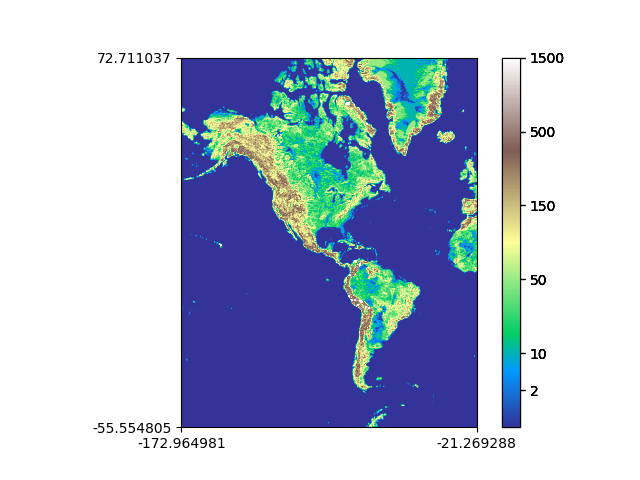

In [21]:
# Plot the western hemisphere map using pyplot
plt.imshow(world_map, cmap=plt.get_cmap("terrain"))
plt.xticks()
cbar = plt.colorbar()
cbar.set_ticks([0.5, 1, 2, 3, 4, 5])
cbar.set_ticklabels(["2", "10", "50", "150", "500", "1500"])

# Latitude and longituted range
lat_limits = [72.711037, -55.554805]
lon_limits = [-172.964981, -21.269288]

# Set the tick positions and labels to underline the lat/long values used
plt.xticks([0, 1023], [str(lon_limits[0]), str(lon_limits[1])])
plt.yticks([0, 1279], [str(lat_limits[0]), str(lat_limits[1])])

%matplot plt


In [22]:
# This has to be in another cell to prevent multiple color bars from appearing when displaying the map
cbar.remove()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…